In [1]:
import pandas as pd
from prog.model import * 
from prog.tools import *
from tqdm import tqdm
import warnings, pickle, time, os, random
warnings.filterwarnings("ignore")

shuffle = True
random_state = None
limit_end = 30
top_score = 3
test_size = 179
model_boundary = 0.5
minute = 5
stop = minute * 60

In [2]:
input_ = {
    "model_id": "20230807120000000",
}
model_id = input_["model_id"]

In [3]:
root = r"C:\Users\tzuli\Documents\python\teco"

# 取得train位置
train_path = os.path.join(root, "data", "train")        
os.makedirs(train_path, exist_ok = True)
data_csv = os.path.join(train_path, "train_data.csv")
output_json = os.path.join(train_path, "output.json")


# 取得model位置
model_path = os.path.join(root, "data", "train", model_id)
os.makedirs(model_path, exist_ok = True)

model_detail = os.path.join(model_path, "model")
os.makedirs(model_detail, exist_ok = True)

In [4]:
df = pd.read_csv(data_csv)
print(df.shape)
df.head(3)

(278, 16)


,日期,工號,序號,平衡轉速,初始_L側角度,初始_L側不平衡量,初始_F側角度,初始_F側不平衡量,平衡_L側角度,平衡_L側配重,平衡_F側角度,平衡_F側配重,最終_L側角度,最終_L側不平衡量,最終_F側角度,最終_F側不平衡量
0,2023-06-01,FC236606T1-2,1,590,12.0,266.0,259.0,181.0,12.0,275.0,259.0,180.0,358.0,58.20,293.0,23.00
1,2023-06-01,FC236606T1-2,2,590,358.0,58.2,293.0,23.0,358.0,60.0,293.0,23.0,307.0,3.50,241.0,3.90
2,2023-06-01,FC236606T1-2,3,590,307.0,3.5,241.0,3.9,307.0,4.0,241.0,4.0,322.0,0.46,214.0,0.36


##### 刪除缺失值

In [5]:
df = df.dropna().reset_index(drop = True)
df.shape

(190, 16)

#### 資料擴增

In [6]:
df_new = pd.DataFrame()
g = df.groupby("工號")
for group in df["工號"].unique():
    df_group0 = g.get_group(group)
    df_group = df_group0.loc[:, "初始_L側角度":]
    df_new = pd.concat([df_new, df_group], ignore_index = True)
    df_diff = df_group.shift(-1) - df_group
    for _ in range(11):
        df_diff1 = df_diff / 10 * random.uniform(1, 9)
        df_group1 = df_group.loc[:, "初始_L側角度":] + df_diff1
        df_group1 = df_group1.dropna()

        df_new = pd.concat([df_new, df_group1], ignore_index = True)

In [7]:
angle_col = [col for col in df.columns if ("角度" in col)]
df_new[angle_col] = df_new[angle_col].round().astype(int)
df_new = df_new.round(2)

check_col = [col for col in df.columns if ("初始" in col) or ("最終" in col)]
df_new = df_new[(df_new[check_col] > 0).all(axis = 1)]

df_new = df_new.drop_duplicates().reset_index(drop = True)
df_new.head(3)

,初始_L側角度,初始_L側不平衡量,初始_F側角度,初始_F側不平衡量,平衡_L側角度,平衡_L側配重,平衡_F側角度,平衡_F側配重,最終_L側角度,最終_L側不平衡量,最終_F側角度,最終_F側不平衡量
0,12,266.0,259,181.0,12,275.0,259,180.0,358,58.20,293,23.00
1,358,58.2,293,23.0,358,60.0,293,23.0,307,3.50,241,3.90
2,307,3.5,241,3.9,307,4.0,241,4.0,322,0.46,214,0.36


In [8]:
df = df_new.copy()

##### 刪除特徵

df = df.drop(['日期', '工號', '序號'], axis = 1)
df.head(3)

#### 預期結果

In [9]:
df = generate_feature(df)
df.head(3)

,初始_L側角度,初始_L側不平衡量,初始_F側角度,初始_F側不平衡量,平衡_L側角度,平衡_L側配重,平衡_F側角度,平衡_F側配重,最終_L側角度,最終_L側不平衡量,最終_F側角度,最終_F側不平衡量,預期_F側不平衡量,預期_L側不平衡量,初始_不平衡量_diff,平衡_不平衡量_diff,初始_角度_diff,平衡_角度_diff
0,12,266.0,259,181.0,12,275.0,259,180.0,358,58.20,293,23.00,1.0,-9.0,85.0,95.0,113,113
1,358,58.2,293,23.0,358,60.0,293,23.0,307,3.50,241,3.90,0.0,-1.8,35.2,37.0,65,65
2,307,3.5,241,3.9,307,4.0,241,4.0,322,0.46,214,0.36,-0.1,-0.5,0.4,0.0,66,66


##### Split

In [10]:
target_vol = ["最終_L側不平衡量", "最終_F側不平衡量"]
target_angle = ["最終_L側角度", "最終_F側角度"]
features = df.columns.drop(target_vol + target_angle).to_list()
features

['初始_L側角度',
 '初始_L側不平衡量',
 '初始_F側角度',
 '初始_F側不平衡量',
 '平衡_L側角度',
 '平衡_L側配重',
 '平衡_F側角度',
 '平衡_F側配重',
 '預期_F側不平衡量',
 '預期_L側不平衡量',
 '初始_不平衡量_diff',
 '平衡_不平衡量_diff',
 '初始_角度_diff',
 '平衡_角度_diff']

In [11]:
l_df = df[df[target_vol[0]] <= limit_end].reset_index(drop = True)
f_df = df[df[target_vol[1]] <= limit_end].reset_index(drop = True)

l_df = l_df.sample(n = 1379, random_state = 99)
f_df = f_df.sample(n = 1379, random_state = 99)

print(f"df: {len(df)}, l_df: {len(l_df)}, f_df: {len(f_df)}")

df: 1535, l_df: 1379, f_df: 1379


### L測預測

In [12]:
side = "L"
total_scores = pd.DataFrame()
total_models = {}
preds = {}
num = 0 # 8, 84
start, end = time.time(), time.time()

pbar = tqdm(total = stop, ncols = 150)
while (end - start) < stop:
    end = time.time()
    train, test = split_data(l_df, test_size, shuffle, random_state = num)
    train, test, outlier_boundary = deal_with_outlier(features, train, test)
    train, test, skew_feat, pt = deal_with_skew(features, train, test)
    train, test, scaler = scaling(features, train, test)

    X_train, X_test = train[features], test[features]
    y_train, y_test = train[target_vol[0]], test[target_vol[0]]

    models = modeling(X_train, y_train, random_state = num)

    scores0, pred_trains, pred_tests = calculate_score(models, X_train, X_test, y_train, y_test, scoring = "r2", cv_flag = 1, cv_scoring = "r2", random_state = num)
    scores = scores0.sort_values(("r2", "test"), ascending = False).iloc[[0]]


    if ((scores["r2"] > model_boundary).values.all()) and (scores.iloc[0][('r2',  'test')] < 0.9):
        preds[num] = {"train": pred_trains, "test": pred_tests}
        total_models[num] = models[scores.index[0]]
        scores["order"] = num
        total_scores = pd.concat([total_scores, scores])
    
    num += 1
    mid = end
    end = time.time()
    pbar.update(round(end - mid, 4))

pbar.close()

100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 299.94029999999987/300 [05:00<00:00,  1.00s/it]


In [13]:
total_scores = total_scores.sort_values([('r2',  'test'), ('r2',  'train'), ('r2',  'cv')], ascending = False)
total_scores.head(3)

mse        rmse        mape          r2             order
               train  test train  test train  test train  test    cv      
Neural Network  6.71  4.11  2.59  2.03  0.52  0.49  0.84  0.89  0.76    93
Neural Network  6.09  5.64  2.47  2.37  0.50  0.54  0.85  0.87  0.84    54
Neural Network  6.48  4.67  2.55  2.16  0.55  0.56  0.85  0.87  0.82   100

In [14]:
best_order = total_scores["order"].iloc[0]
best_score = total_scores.iloc[[0]]
best_score = best_score.drop("order", axis = 1)
best_score.to_csv(os.path.join(model_path, f"{side}_score.csv"))
model = total_models[best_order]
print(best_order)
best_score

93


mse        rmse        mape          r2            
               train  test train  test train  test train  test    cv
Neural Network  6.71  4.11  2.59  2.03  0.52  0.49  0.84  0.89  0.76

In [15]:
pickle.dump(features, open(os.path.join(model_detail, "feat_order.pkl"), "wb"))
pickle.dump(outlier_boundary, open(os.path.join(model_detail, f"{side}_outlier_boundary.pkl"), "wb"))
pickle.dump(skew_feat, open(os.path.join(model_detail, f"{side}_skew_feat.pkl"), "wb"))
pickle.dump(pt, open(os.path.join(model_detail, f"{side}_power_tf.pkl"), "wb"))
pickle.dump(scaler, open(os.path.join(model_detail, f"{side}_scaler.pkl"), "wb"))
pickle.dump(model, open(os.path.join(model_detail, f"{side}_model.pkl"), "wb"))

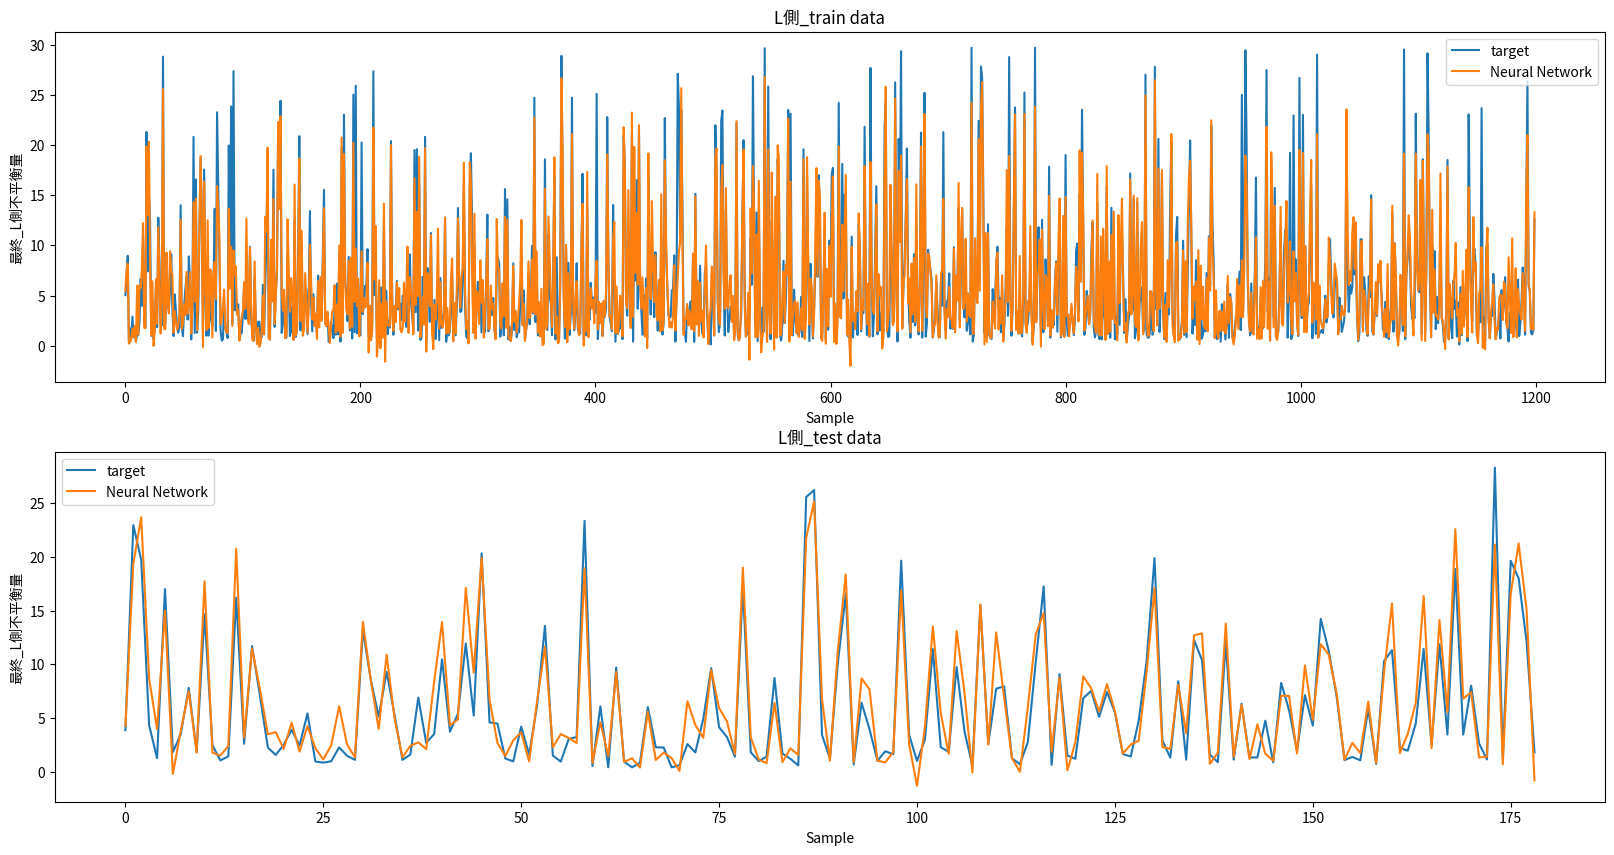

In [16]:
pred_trains, pred_tests = preds[best_order]["train"], preds[best_order]["test"]
pred_plot(pred_trains, pred_tests, best_score, target_vol[0], model_path, side, top_score = 3)

### F測預測

In [17]:
side = "F"
total_scores = pd.DataFrame()
total_models = {}
preds = {}
num = 0 # 681, 59
start, end = time.time(), time.time()

pbar = tqdm(total = stop, ncols = 150)
while (end - start) < stop:
    end = time.time()
    train, test = split_data(f_df, test_size, shuffle, random_state = num)
    train, test, outlier_boundary = deal_with_outlier(features, train, test)
    train, test, skew_feat, pt = deal_with_skew(features, train, test)
    train, test, scaler = scaling(features, train, test)

    X_train, X_test = train[features], test[features]
    y_train, y_test = train[target_vol[1]], test[target_vol[1]]

    models = modeling(X_train, y_train, random_state = num)

    scores0, pred_trains, pred_tests = calculate_score(models, X_train, X_test, y_train, y_test, scoring = "r2", cv_flag = 1, cv_scoring = "r2", random_state = num)
    scores = scores0.sort_values(("r2", "test"), ascending = False).iloc[[0]]


    if (scores["r2"] > model_boundary).values.all():
        preds[num] = {"train": pred_trains, "test": pred_tests}
        total_models[num] = models[scores.index[0]]
        scores["order"] = num
        total_scores = pd.concat([total_scores, scores])
    
    num += 1
    mid = end
    end = time.time()
    pbar.update(round(end - mid, 4))

pbar.close()

301.263it [05:01,  1.00s/it]                                                                                                                          


In [18]:
total_scores = total_scores.sort_values([('r2',  'test'), ('r2',  'train'), ('r2',  'cv')], ascending = False)
total_scores.head(3)

mse        rmse        mape          r2             order
               train  test train  test train  test train  test    cv      
Neural Network  5.89  4.01  2.43  2.00  0.48  0.56  0.85  0.91  0.85    42
Neural Network  5.34  3.73  2.31  1.93  0.45  0.49  0.86  0.90  0.87    31
Neural Network  5.68  4.15  2.38  2.04  0.47  0.53  0.85  0.90  0.81    35

In [19]:
best_order = total_scores["order"].iloc[0]
best_score = total_scores.iloc[[0]]
best_score = best_score.drop("order", axis = 1)
best_score.to_csv(os.path.join(model_path, f"{side}_score.csv"))
model = total_models[best_order]
print(best_order)
best_score

42


mse        rmse       mape          r2            
               train  test train test train  test train  test    cv
Neural Network  5.89  4.01  2.43  2.0  0.48  0.56  0.85  0.91  0.85

In [20]:
pickle.dump(features, open(os.path.join(model_detail, "feat_order.pkl"), "wb"))
pickle.dump(outlier_boundary, open(os.path.join(model_detail, f"{side}_outlier_boundary.pkl"), "wb"))
pickle.dump(skew_feat, open(os.path.join(model_detail, f"{side}_skew_feat.pkl"), "wb"))
pickle.dump(pt, open(os.path.join(model_detail, f"{side}_power_tf.pkl"), "wb"))
pickle.dump(scaler, open(os.path.join(model_detail, f"{side}_scaler.pkl"), "wb"))
pickle.dump(model, open(os.path.join(model_detail, f"{side}_model.pkl"), "wb"))

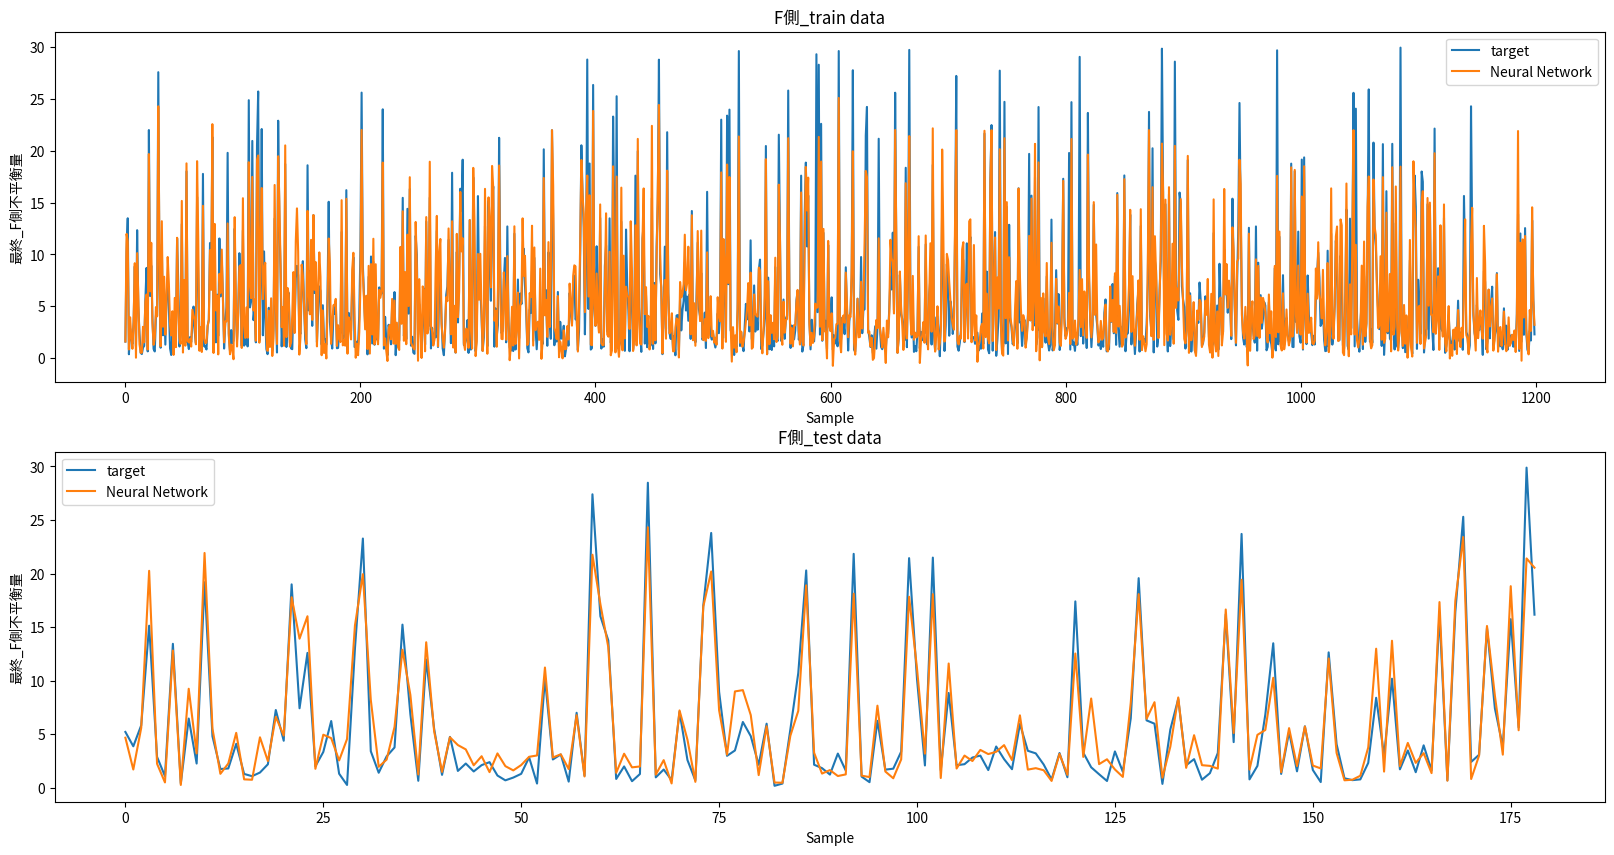

In [21]:
pred_trains, pred_tests = preds[best_order]["train"], preds[best_order]["test"]
pred_plot(pred_trains, pred_tests, best_score, target_vol[1], model_path, side, top_score = 3)